In [1]:
import os
import numpy as np
import pandas as pd
import supervision as sv
from supervision.metrics import MeanAveragePrecision

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
# Configuration files
model_configs = [
    {
        'train': 'Thera Haryana',
        'test': 'Thera Test Bihar',
        'backbone': 'swint',
        'head': 'rhino',
        'config_file': '/home/shardul.junagade/my-work/domain-adaptation-brick-kilns/RHINO/configs-mine/rhino-swint-dota2config/rhino_phc_haus-4scale_swint_2xb2-36e_thera_haryana.py',
        'checkpoint_folder': '/home/shardul.junagade/my-work/domain-adaptation-brick-kilns/RHINO/work_dirs/rhino_phc_haus-4scale_swint_2xb2-36e_thera_haryana',
        'checkpoint_file': '/home/shardul.junagade/my-work/domain-adaptation-brick-kilns/RHINO/work_dirs/rhino_phc_haus-4scale_swint_2xb2-36e_thera_haryana/epoch_45.pth',
        'val_dir': '/home/shardul.junagade/my-work/domain-adaptation-brick-kilns/data/thera_rdn_pro/test_bihar_4x',
        'inf_dir': '/home/shardul.junagade/my-work/domain-adaptation-brick-kilns/RHINO/results-swint/thera_haryana_to_test_bihar',
        'img_height': 2560,
        'epoch': 45,
    },
]

In [4]:
def get_image_names_from_directory(directory):
    """Extracts image names (without extension) from a directory."""
    return {file_name.replace(".txt", "") for file_name in os.listdir(directory) if file_name.endswith(".txt")}

def load_detections(annotations_path, img_names, is_gt=True):
    """Loads detections only for images that exist in both GT and Predictions."""
    sv_data = []

    for image_id in sorted(img_names):
        file_path = os.path.join(annotations_path, f"{image_id}.txt")
        if not os.path.exists(file_path):  # Ensure file exists before processing
            continue

        xyxy_list = []
        class_ids = []
        scores = []

        with open(file_path, "r") as file:
            lines = file.readlines()

        for line in lines:
            data = list(map(float, line.split()))
            class_id = int(data[0])
            polygon = np.array(data[1:9]).reshape(4, 2)  # Convert to (4,2) shape
            score = data[9] if not is_gt else 1.0  # Default confidence for GT is 1.0

            # Convert quadrilateral to bounding box (min x, min y, max x, max y)
            x_min, y_min = np.min(polygon, axis=0)
            x_max, y_max = np.max(polygon, axis=0)
            bbox = [x_min, y_min, x_max, y_max]

            # Append to lists
            xyxy_list.append(bbox)
            class_ids.append(class_id)
            scores.append(score)
        
        if not xyxy_list:
            detection = sv.Detections(
                xyxy=np.array([[0, 0, 0, 0]]),
                class_id=np.array([0]),
                confidence=np.array([0]),
                metadata={"image_id": image_id}
            )
        
        else:
           # Convert lists into a Supervision Detections object
            detections = sv.Detections(
                xyxy=np.array(xyxy_list),
                class_id=np.array(class_ids),
                confidence=np.array(scores),
                metadata={"image_id": image_id}
            )

        sv_data.append(detections)

    return sv_data

def get_class_counts(detections_list, num_classes=3):
    """Counts occurrences of each class in ground truth detections."""
    class_counts = np.zeros(num_classes)
    for detections in detections_list:
        unique, counts = np.unique(detections.class_id, return_counts=True)
        for cls, count in zip(unique, counts):
            class_counts[cls] += count
    return class_counts

In [5]:
index = pd.MultiIndex.from_tuples([], names=["Base State", "Target State", "Epochs"])
result_df = pd.DataFrame(columns=["CFCBK", "FCBK", "Zigzag", "Weighted mAP@50", "mAP@50:95", "mAP@50", "mAP@75", "CA mAP@50:95", "CA mAP@50", "CA mAP@75"], index=index)

In [6]:
model_config = model_configs[0]

In [20]:
for epoch in range(31, model_config['epoch'] + 1)[::-1]:
    # Load image names from directories
    GT_PATH = os.path.join(model_config['val_dir'], "labels")
    # print(f"GT path: {GT_PATH}")
    if not os.path.exists(GT_PATH):
        print(f"GT path {GT_PATH} does not exist.")
        break
    PREDICTIONS_PATH = os.path.join(model_config['inf_dir'], f"epoch_{epoch}_supervision_conf_0.01_nms_0.33", "annfiles")
    if not os.path.exists(PREDICTIONS_PATH):
        print(f"Predictions path {PREDICTIONS_PATH} does not exist.")
        continue
    gt_img_names = get_image_names_from_directory(GT_PATH)
    pred_img_names = get_image_names_from_directory(PREDICTIONS_PATH)
    img_names = gt_img_names.intersection(pred_img_names)
    base_state = model_config['train']
    target_state = model_config['test']

    # Load GT and Predictions
    gt_data = load_detections(GT_PATH, img_names, is_gt=True)
    pred_data = load_detections(PREDICTIONS_PATH, img_names, is_gt=False)

    # Print mAP results
    print(f"\n{model_config['train']} to {model_config['test']} (Epoch {epoch}):")
    ## mAP calculation (non-class agnostic)
    mAP_metric = MeanAveragePrecision(class_agnostic=False)
    mAP_result = mAP_metric.update(pred_data, gt_data).compute()
    matched_classes = mAP_result.matched_classes.tolist()
    # print(f"    Matched classes: {matched_classes}")
    # Extract overall mAP values
    mAP_50_95 = mAP_result.map50_95  # mAP 50:95
    mAP_50 = mAP_result.map50  # mAP 50
    mAP_75 = mAP_result.map75  # mAP 75
    print(f"    mAP 50:95: {mAP_50_95}, mAP 50: {mAP_50}, mAP 75: {mAP_75}")

    # Extract class-wise mAP
    class_wise_mAP = mAP_result.ap_per_class[:, 0].tolist()  # mAP 50:95 per class
    num_classes = 3
    final_class_wise_mAP = [0] * num_classes
    for cls, mAP in zip(matched_classes, class_wise_mAP):
        final_class_wise_mAP[cls] = mAP
    print(f"    class_wise_mAP: {final_class_wise_mAP}\n")
    # Calculate weighted mAP
    class_counts = get_class_counts(gt_data, num_classes=num_classes)
    print(f"    class_counts: {class_counts}")
    weighted_mAP_50 = np.sum(np.array(final_class_wise_mAP) * class_counts) / np.sum(class_counts)
    print(f"    Weighted mAP 50: {weighted_mAP_50}\n")

    # Compute class-agnostic mAP
    mAP_metric_agnostic = MeanAveragePrecision(class_agnostic=True)
    mAP_result_agnostic = mAP_metric_agnostic.update(pred_data, gt_data).compute()
    # Extract class-agnostic mAP values
    mAP_50_95_agnostic = mAP_result_agnostic.map50_95  # mAP 50:95
    mAP_50_agnostic = mAP_result_agnostic.map50  # mAP 50
    mAP_75_agnostic = mAP_result_agnostic.map75  # mAP 75
    print(f"    CA mAP 50:95: {mAP_50_95_agnostic}, CA mAP 50: {mAP_50_agnostic}, CA mAP 75: {mAP_75_agnostic}")

    # Update results dataframe
    result_df.loc[(base_state, target_state, epoch), :] = [f"{x:.6f}" for x in final_class_wise_mAP + [weighted_mAP_50, mAP_50_95, mAP_50, mAP_75, mAP_50_95_agnostic, mAP_50_agnostic, mAP_75_agnostic]]



Thera Haryana to Thera Test Bihar (Epoch 45):
    mAP 50:95: 0.09055032900955869, mAP 50: 0.19697021773537082, mAP 75: 0.06019260522956435
    class_wise_mAP: [0.0, 0.008398256007086855, 0.5825123971990256]

    class_counts: [  10.  120. 1000.]
    Weighted mAP 50: 0.5163895468317486

    CA mAP 50:95: 0.2720588326389806, CA mAP 50: 0.6054482591738186, CA mAP 75: 0.17502730964164726

Thera Haryana to Thera Test Bihar (Epoch 44):
    mAP 50:95: 0.0906264606746086, mAP 50: 0.19773535514334184, mAP 75: 0.06152227888962533
    class_wise_mAP: [0.0, 0.007316563306500698, 0.5858895021235249]

    class_counts: [  10.  120. 1000.]
    Weighted mAP 50: 0.5192632652392078

    CA mAP 50:95: 0.2728264395037198, CA mAP 50: 0.6047438607629083, CA mAP 75: 0.18086218992472491

Thera Haryana to Thera Test Bihar (Epoch 43):
    mAP 50:95: 0.09289876161301149, mAP 50: 0.19992878126143424, mAP 75: 0.0660384500077476
    class_wise_mAP: [0.0, 0.007572104888100924, 0.5922142388962018]

    class_counts:

In [21]:
display(result_df)

CFCBK      FCBK    Zigzag  \
Base State    Target State     Epochs                                 
Thera Haryana Thera Test Bihar 45      0.000000  0.008398  0.582512   
                               44      0.000000  0.007317  0.585890   
                               43      0.000000  0.007572  0.592214   
                               42      0.000000  0.006869  0.581689   
                               41      0.000000  0.008068  0.586809   
                               40      0.000000  0.007874  0.591574   
                               39      0.000000  0.006951  0.586509   
                               38      0.000000  0.007649  0.585579   
                               37      0.000000  0.008638  0.585994   
                               36      0.000000  0.009471  0.582604   
                               35      0.000000  0.007186  0.579103   
                               34      0.000000  0.008142  0.570792   
                               33      0.000000  0.008916  0.563396   
                               32      0.000000  0.005826  0.557526   
                               31      0.000000  0.005127  0.475936   

                                      Weighted mAP@50 mAP@50:95    mAP@50  \
Base State    Target State     Epochs                                       
Thera Haryana Thera Test Bihar 45            0.516390  0.090550  0.196970   
                               44            0.519263  0.090626  0.197735   
                               43            0.524888  0.092899  0.199929   
                               42            0.515498  0.089979  0.196186   
                               41            0.520157  0.091390  0.198293   
                               40            0.524353  0.091657  0.199816   
                               39            0.519773  0.090821  0.197820   
                               38            0.519024  0.089908  0.197743   
                               37            0.519496  0.090101  0.198211   
                               36            0.516584  0.090200  0.197358   
                               35            0.513243  0.089652  0.195429   
                               34            0.505990  0.088475  0.192978   
                               33            0.499527  0.087497  0.190771   
                               32            0.494005  0.084831  0.187784   
                               31            0.393961  0.062112  0.160354   

                                         mAP@75 CA mAP@50:95 CA mAP@50  \
Base State    Target State     Epochs                                    
Thera Haryana Thera Test Bihar 45      0.060193     0.272059  0.605448   
                               44      0.061522     0.272826  0.604744   
                               43      0.066038     0.278087  0.610282   
                               42      0.061204     0.271051  0.602248   
                               41      0.064612     0.273172  0.606150   
                               40      0.063897     0.273679  0.607433   
                               39      0.058746     0.273630  0.608384   
                               38      0.057285     0.269339  0.604917   
                               37      0.057248     0.270994  0.608015   
                               36      0.058510     0.270992  0.605912   
                               35      0.059290     0.268661  0.601610   
                               34      0.058264     0.266455  0.595385   
                               33      0.057963     0.264591  0.590449   
                               32      0.057700     0.259065  0.584846   
                               31      0.030518     0.180562  0.483898   

                                      CA mAP@75  
Base State    Target State     Epochs            
Thera Haryana Thera Test Bihar 45      0.175027  
                               44      0.180862  
                               43      0.193519  
               

In [ ]:
# # Save the dataframe as CSV
# result_df.to_csv(f"../../RHINO/results-{model_config['backbone']}/{model_config['train']}_{model_config['test']}_{model_config['head']}_epoch_results.csv")

In [11]:
import pandas as pd
# saved_df = pd.read_csv(f"../results-{model_config['backbone']}/{model_config['train']}_{model_config['test']}_{model_config['head']}_epoch_results.csv", index_col=[0, 1, 2])
saved_df = pd.read_csv("/home/shardul.junagade/my-work/domain-adaptation-brick-kilns/RHINO/results-swint/Thera Haryana_Thera Test Bihar_rhino_epoch_results.csv", index_col=[0, 1, 2])
# display(saved_df)

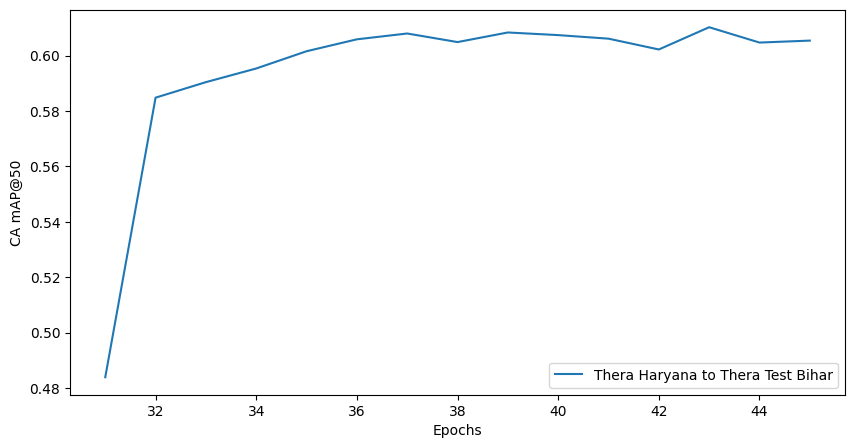

In [12]:
ca_mAP_df = saved_df.reset_index()[["Epochs", "CA mAP@50"]].set_index("Epochs")
# display(ca_mAP_df)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(ca_mAP_df.index, ca_mAP_df["CA mAP@50"], label=f"{model_config['train']} to {model_config['test']}")
plt.xlabel("Epochs")
plt.ylabel("CA mAP@50")
plt.legend()
plt.savefig(f"../../RHINO/results-{model_config['backbone']}/{model_config['train']}_{model_config['test']}_{model_config['head']}_epoch_results.png", dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# # Filter to include only epochs up to 50
# ca_mAP_df = ca_mAP_df[ca_mAP_df.index <= 50]
# Sort by CA mAP@50 values
sorted_df = ca_mAP_df.sort_values(by="CA mAP@50", ascending=False)
display(sorted_df)

,CA mAP@50
Epochs,
43,0.610282
39,0.608384
37,0.608015
40,0.607433
41,0.606150
36,0.605912
45,0.605448
38,0.604917
44,0.604744


In [14]:
best_epoch = sorted_df.index[0]
print(f"Best epoch: {best_epoch}")
print(f"Best CA mAP@50: {sorted_df.iloc[0, 0]}")

Best epoch: 43
Best CA mAP@50: 0.610282
